# K-Nearest Neighbors (KNN)


## Preparação do ambiente
Utilizaremos apenas `NumPy` e `matplotlib` para a implementação e visualizações.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True)
rng = np.random.default_rng(42)


## O que é KNN e para que serve?

**K-Nearest Neighbors (KNN)** é um método de **aprendizado supervisionado** que prediz a saída de uma nova amostra
com base nas **K amostras mais próximas** no conjunto de treino, segundo uma **métrica de distância** escolhida.

- **Classificação**: a classe predita é (tipicamente) a **maioria** entre os K vizinhos (ou uma média ponderada por distância).  
- **Regressão**: a predição é a **média** (ou média ponderada) dos valores alvo dos K vizinhos.  
- É um método **preguiçoso** (*lazy learning*): **não ajusta** parâmetros globais; armazena os dados de treino e calcula distâncias na hora da consulta.

**Vantagens**  
- Simples, intuitivo e competitivo em muitos cenários.  
- Naturalmente **não linear** (fronteiras complexas).  
- Poucas suposições sobre a forma da função verdadeira.

**Desvantagens**  
- **Custo de predição** potencialmente alto (compara com todas as amostras).  
- Sensível a **escala** das features e à **escolha da métrica**.  
- Sofre com a **maldição da dimensionalidade** (distâncias se tornam pouco discriminativas em alta dimensão).


## Métricas de distância suportadas neste notebook
- **Euclidiana (L2)**, **Manhattan (L1)**, **Minkowski (ordem p)**, **Chebyshev (L∞)**  
- **Similaridade do Cosseno** (usada como distância = 1 - similaridade)  
- **Mahalanobis** (usa matriz de covariância para levar correlação em conta)

> Dica: padronize as features (z-score) antes de usar métricas Lp (L1/L2/...). Para texto/embeddings, o **cosseno** costuma ser mais adequado.


In [2]:
# ---------------- Utilidades de pré-processamento e distância ----------------

def zscore(X, eps=1e-12):
    X = np.asarray(X, dtype=float)
    mu = X.mean(axis=0)
    sd = X.std(axis=0)
    sd = np.where(sd < eps, 1.0, sd)
    return (X - mu) / sd, mu, sd

def apply_zscore(X, mu, sd):
    sd_safe = np.where(sd==0, 1.0, sd)
    return (X - mu) / sd_safe

def pairwise_distances(A, B, metric='euclidean', p=2, VI=None, eps=1e-12):
    """Retorna matriz de distâncias MxN entre linhas de A (Mxd) e B (Nxd)."""
    A = np.asarray(A, dtype=float)
    B = np.asarray(B, dtype=float)
    if metric in ('euclidean', 'minkowski', 'manhattan', 'chebyshev'):
        diff = A[:,None,:] - B[None,:,:]  # (M,N,d)
        if metric == 'euclidean':
            return np.linalg.norm(diff, axis=2)
        if metric == 'manhattan':
            return np.sum(np.abs(diff), axis=2)
        if metric == 'minkowski':
            return np.sum(np.abs(diff)**p, axis=2)**(1.0/p)
        if metric == 'chebyshev':
            return np.max(np.abs(diff), axis=2)
    elif metric == 'cosine':
        # distância de cosseno = 1 - (a·b)/(||a|| ||b||)
        A_norm = np.linalg.norm(A, axis=1, keepdims=True)
        B_norm = np.linalg.norm(B, axis=1, keepdims=True)
        A_safe = np.where(A_norm==0, 0, A / np.maximum(A_norm, eps))
        B_safe = np.where(B_norm==0, 0, B / np.maximum(B_norm, eps))
        sim = A_safe @ B_safe.T
        return 1.0 - sim
    elif metric == 'mahalanobis':
        if VI is None:
            raise ValueError("Forneça Σ^{-1} (VI) para distância de Mahalanobis.")
        diff = A[:,None,:] - B[None,:,:]  # (M,N,d)
        # d^2 = (a-b)^T VI (a-b)
        d2 = np.einsum('mnd,df,mnd->mn', diff, VI, diff)
        return np.sqrt(np.maximum(d2, 0.0))
    else:
        raise ValueError("Métrica desconhecida: %r" % metric)


## Implementação do KNN (do zero)
Abaixo estão implementações simples de **KNN Classifier** e **KNN Regressor** com opções:
- `n_neighbors` (*k*), `metric`, `p` (para Minkowski), `weights` (`'uniform'` ou `'distance'`), `standardize` (z-score).  
- Em classificação, `predict_proba` retorna probabilidades por voto (ponderado ou não).


In [3]:
class KNNClassifier:
    def __init__(self, n_neighbors=5, metric='euclidean', p=2, weights='uniform', standardize=True, VI=None):
        self.k = int(n_neighbors)
        self.metric = metric
        self.p = p
        self.weights = weights
        self.standardize = standardize
        self.VI = VI  # para Mahalanobis
        self._fitted = False

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y)
        self.classes_, y_enc = np.unique(y, return_inverse=True)
        self.X_train = X.copy()
        self.y_train = y_enc.astype(int)
        self.n_features_ = X.shape[1]
        # padronização
        if self.standardize and self.metric != 'cosine':  # cosseno já é invariável a escala
            self.X_train, self.mu_, self.sd_ = zscore(self.X_train)
        else:
            self.mu_, self.sd_ = np.zeros(self.n_features_), np.ones(self.n_features_)
        # checagem Mahalanobis
        if self.metric == 'mahalanobis' and self.VI is None:
            # estima Σ a partir dos dados padronizados/transformados
            Σ = np.cov(self.X_train, rowvar=False)
            Σ += 1e-6*np.eye(Σ.shape[0])
            self.VI = np.linalg.inv(Σ)
        self._fitted = True
        return self

    def _transform(self, X):
        X = np.asarray(X, dtype=float)
        if self.standardize and self.metric != 'cosine':
            return apply_zscore(X, self.mu_, self.sd_)
        return X

    def predict_proba(self, X):
        assert self._fitted, "Chame fit primeiro."
        Xq = self._transform(X)
        D = pairwise_distances(Xq, self.X_train, metric=self.metric, p=self.p, VI=self.VI)
        n, k = Xq.shape[0], min(self.k, self.X_train.shape[0])
        idx = np.argpartition(D, kth=k-1, axis=1)[:, :k]  # vizinhos não ordenados
        # ordenar cada linha por distância crescente
        row_idx = np.arange(n)[:, None]
        idx_sorted = idx[row_idx, np.argsort(D[row_idx, idx], axis=1)]
        d_sorted = D[row_idx, idx_sorted]
        # pesos
        if self.weights == 'distance':
            w = 1.0 / (d_sorted + 1e-12)
        else:
            w = np.ones_like(d_sorted)
        # agregação por classe
        C = len(self.classes_)
        proba = np.zeros((n, C), dtype=float)
        for i in range(n):
            for j, jj in enumerate(idx_sorted[i]):
                proba[i, self.y_train[jj]] += w[i, j]
            s = proba[i].sum()
            if s > 0:
                proba[i] /= s
        return proba

    def predict(self, X):
        proba = self.predict_proba(X)
        # desempate: maior prob; em empate, usa a classe do vizinho mais próximo
        y_pred = np.argmax(proba, axis=1)
        return self.classes_[y_pred]


class KNNRegressor:
    def __init__(self, n_neighbors=5, metric='euclidean', p=2, weights='uniform', standardize=True, VI=None):
        self.k = int(n_neighbors)
        self.metric = metric
        self.p = p
        self.weights = weights
        self.standardize = standardize
        self.VI = VI
        self._fitted = False

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float).reshape(-1)
        self.X_train = X.copy()
        self.y_train = y.copy()
        self.n_features_ = X.shape[1]
        if self.standardize and self.metric != 'cosine':
            self.X_train, self.mu_, self.sd_ = zscore(self.X_train)
        else:
            self.mu_, self.sd_ = np.zeros(self.n_features_), np.ones(self.n_features_)
        if self.metric == 'mahalanobis' and self.VI is None:
            Σ = np.cov(self.X_train, rowvar=False)
            Σ += 1e-6*np.eye(Σ.shape[0])
            self.VI = np.linalg.inv(Σ)
        self._fitted = True
        return self

    def _transform(self, X):
        X = np.asarray(X, dtype=float)
        if self.standardize and self.metric != 'cosine':
            return apply_zscore(X, self.mu_, self.sd_)
        return X

    def predict(self, X):
        assert self._fitted, "Chame fit primeiro."
        Xq = self._transform(X)
        D = pairwise_distances(Xq, self.X_train, metric=self.metric, p=self.p, VI=self.VI)
        n, k = Xq.shape[0], min(self.k, self.X_train.shape[0])
        idx = np.argpartition(D, kth=k-1, axis=1)[:, :k]
        row_idx = np.arange(n)[:, None]
        idx_sorted = idx[row_idx, np.argsort(D[row_idx, idx], axis=1)]
        d_sorted = D[row_idx, idx_sorted]
        if self.weights == 'distance':
            w = 1.0 / (d_sorted + 1e-12)
        else:
            w = np.ones_like(d_sorted)
        y_pred = np.zeros(n, dtype=float)
        for i in range(n):
            ww = w[i]
            yy = self.y_train[idx_sorted[i]]
            s = ww.sum()
            y_pred[i] = (ww @ yy) / s if s > 0 else yy.mean()
        return y_pred


# Métricas de avaliação simples
def train_test_split(X, y, test_size=0.3, shuffle=True):
    X = np.asarray(X); y = np.asarray(y)
    n = len(X)
    idx = np.arange(n)
    if shuffle:
        rng.shuffle(idx)
    n_test = int(round(n*test_size))
    te = idx[:n_test]; tr = idx[n_test:]
    return X[tr], X[te], y[tr], y[te]

def accuracy_score(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    return float(np.mean(y_true == y_pred))

def rmse(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float); y_pred = np.asarray(y_pred, dtype=float)
    return float(np.sqrt(np.mean((y_true - y_pred)**2)))


## Conjuntos de dados de exemplo
Vamos usar dois conjuntos sintéticos para **classificação 2D** e um conjunto 1D para **regressão**.


In [4]:
# Duas 'luas' simples (sem depender de scikit-learn)
def make_two_moons(n_samples=300, noise=0.25, seed=42):
    rng_local = np.random.default_rng(seed)
    n = n_samples // 2
    t1 = rng_local.random(n) * np.pi
    t2 = rng_local.random(n) * np.pi
    X1 = np.stack([np.cos(t1), np.sin(t1)], axis=1)
    X2 = np.stack([1.0 - np.cos(t2), -np.sin(t2) + 0.5], axis=1)
    X = np.vstack([X1, X2]) + noise * rng_local.normal(size=(2*n,2))
    y = np.array([0]*n + [1]*n)
    return X, y

X_moon, y_moon = make_two_moons(n_samples=400, noise=0.18, seed=7)
Xtr_m, Xte_m, ytr_m, yte_m = train_test_split(X_moon, y_moon, test_size=0.3)

# Regressão 1D: y = sin(x) + ruído
def make_regression_curve(n=200, noise=0.2, seed=42):
    rng_local = np.random.default_rng(seed)
    X = rng_local.uniform(-3.5, 3.5, size=(n,1))
    y = np.sin(X[:,0]) + noise * rng_local.normal(size=n)
    return X, y

Xr, yr = make_regression_curve(n=240, noise=0.25, seed=1)
Xtr_r, Xte_r, ytr_r, yte_r = train_test_split(Xr, yr, test_size=0.3)

print("Moons:", X_moon.shape, " | Regressão:", Xr.shape)


Moons: (400, 2)  | Regressão: (240, 1)


## Fronteiras de decisão (classificação)
Comparando **k=1**, **k=15** e **k=35** com métrica Euclidiana e padronização ligada (padrão).


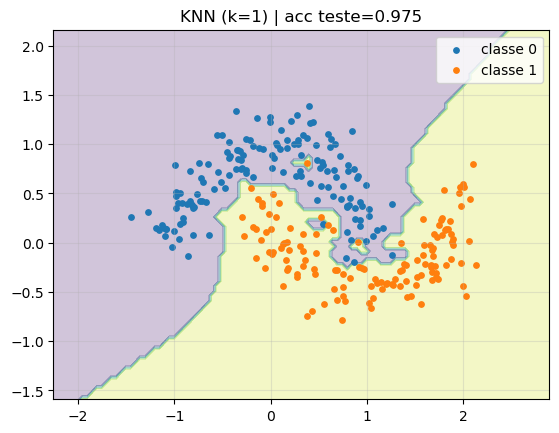

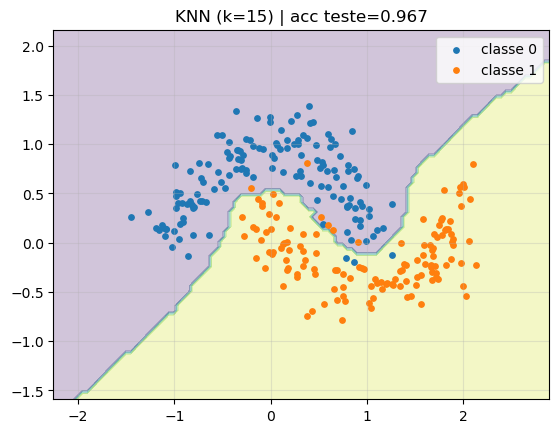

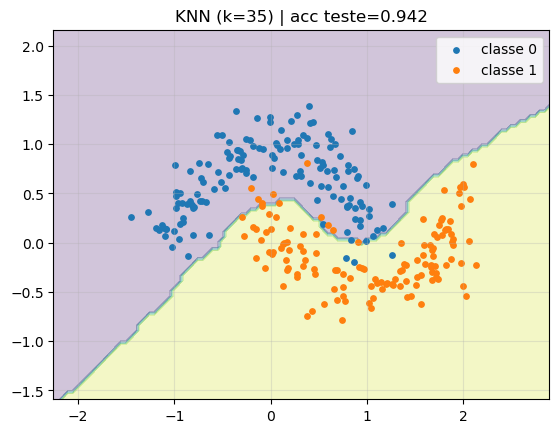

In [5]:
def plot_decision_surface(model, X, y, title="", h=0.05, margin=0.8):
    x_min, x_max = X[:,0].min()-margin, X[:,0].max()+margin
    y_min, y_max = X[:,1].min()-margin, X[:,1].max()+margin
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]
    zz = model.predict(grid).reshape(xx.shape)
    plt.figure()
    plt.contourf(xx, yy, zz, alpha=0.25)
    # plot pontos de treino por classe
    for c in np.unique(y):
        sel = (y==c)
        plt.scatter(X[sel,0], X[sel,1], s=15, label=f"classe {c}")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

for k in [1, 15, 35]:
    clf = KNNClassifier(n_neighbors=k, metric='euclidean', standardize=True, weights='uniform')
    clf.fit(Xtr_m, ytr_m)
    ypred = clf.predict(Xte_m)
    acc = accuracy_score(yte_m, ypred)
    plot_decision_surface(clf, Xtr_m, ytr_m, title=f"KNN (k={k}) | acc teste={acc:.3f}")


## Escolha de *k* e **trade-off viés–variância**
Usamos **validação cruzada** (k-fold) no treino para selecionar *k*.  
Abaixo, avaliamos *k* em uma grade e pegamos o melhor pela **acurácia média**.


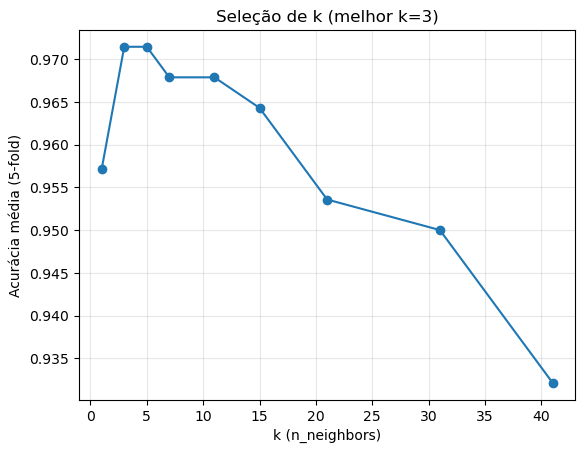

Melhor k = 3 | Acurácia no teste = 0.9833


In [6]:
def kfold_indices(n, n_splits=5, seed=42):
    rng_local = np.random.default_rng(seed)
    idx = np.arange(n); rng_local.shuffle(idx)
    folds = np.array_split(idx, n_splits)
    for i in range(n_splits):
        te = folds[i]
        tr = np.hstack([folds[j] for j in range(n_splits) if j!=i])
        yield tr, te

k_grid = [1,3,5,7,11,15,21,31,41]
scores = []
for k in k_grid:
    fold_acc = []
    for tr, te in kfold_indices(len(Xtr_m), n_splits=5):
        clf = KNNClassifier(n_neighbors=k, metric='euclidean', standardize=True, weights='uniform')
        clf.fit(Xtr_m[tr], ytr_m[tr])
        pred = clf.predict(Xtr_m[te])
        fold_acc.append(accuracy_score(ytr_m[te], pred))
    scores.append(np.mean(fold_acc))

best_k = int(k_grid[int(np.argmax(scores))])
plt.figure()
plt.plot(k_grid, scores, marker='o')
plt.xlabel("k (n_neighbors)")
plt.ylabel("Acurácia média (5-fold)")
plt.title(f"Seleção de k (melhor k={best_k})")
plt.grid(True, alpha=0.3)
plt.show()

# Treina modelo final com k ótimo e avalia no teste
clf_best = KNNClassifier(n_neighbors=best_k, metric='euclidean', standardize=True, weights='uniform')
clf_best.fit(Xtr_m, ytr_m)
acc_test = accuracy_score(yte_m, clf_best.predict(Xte_m))
print(f"Melhor k = {best_k} | Acurácia no teste = {acc_test:.4f}")


## Pesos por distância vs. voto uniforme
Vizinho mais próximo **ponderado por distância** pode melhorar desempenho quando há **mistura de densidades**.
Comparamos `weights='uniform'` vs `weights='distance'`.


In [7]:
for weights in ['uniform', 'distance']:
    clf_w = KNNClassifier(n_neighbors=15, metric='euclidean', standardize=True, weights=weights)
    clf_w.fit(Xtr_m, ytr_m)
    acc = accuracy_score(yte_m, clf_w.predict(Xte_m))
    print(f"weights={weights:9s} | acc teste = {acc:.4f}")


weights=uniform   | acc teste = 0.9667
weights=distance  | acc teste = 0.9833


## Efeito da **padronização** (z-score)
Criamos uma versão do conjunto com **escalas muito diferentes** entre as features e comparamos a acurácia com/sem `standardize`.


In [8]:
X_scaled = Xtr_m.copy()
X_scaled[:,0] *= 50.0  # estica 1º eixo
Xte_scaled = Xte_m.copy()
Xte_scaled[:,0] *= 50.0

for std in [False, True]:
    clf = KNNClassifier(n_neighbors=15, metric='euclidean', standardize=std)
    clf.fit(X_scaled, ytr_m)
    acc = accuracy_score(yte_m, clf.predict(Xte_scaled))
    print(f"standardize={std} | acc teste = {acc:.4f}")


standardize=False | acc teste = 0.7833
standardize=True | acc teste = 0.9667


## KNN para **Regressão**
Comparamos o efeito de *k* (suavização) e de `weights` em uma curva ruidosa \(y=\sin(x)+\varepsilon\).

k= 1 | RMSE teste = 0.3145
k= 5 | RMSE teste = 0.2614
k=25 | RMSE teste = 0.2601


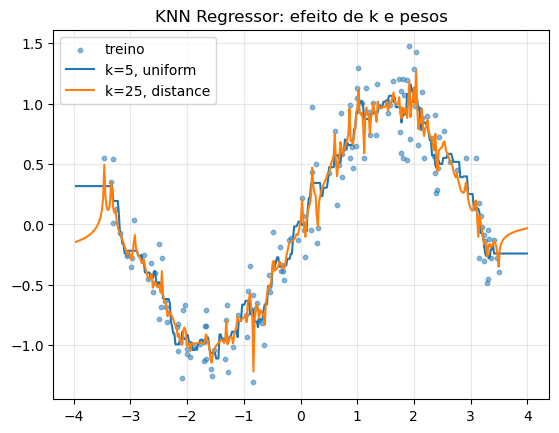

In [9]:
# k pequenos ~ variância alta; k grandes ~ viés alto (super-suavização)
for k in [1,5,25]:
    kr = KNNRegressor(n_neighbors=k, metric='euclidean', standardize=True, weights='uniform')
    kr.fit(Xtr_r, ytr_r)
    pred = kr.predict(Xte_r)
    print(f"k={k:2d} | RMSE teste = {rmse(yte_r, pred):.4f}")

# Visual do ajuste com k=5 (uniform) e k=25 (distance)
xs = np.linspace(Xr.min()-0.5, Xr.max()+0.5, 400).reshape(-1,1)
plt.figure()
plt.scatter(Xtr_r[:,0], ytr_r, s=10, alpha=0.5, label="treino")
kr5 = KNNRegressor(n_neighbors=5, metric='euclidean', standardize=True, weights='uniform').fit(Xtr_r, ytr_r)
kr25d = KNNRegressor(n_neighbors=25, metric='euclidean', standardize=True, weights='distance').fit(Xtr_r, ytr_r)
plt.plot(xs[:,0], kr5.predict(xs), label="k=5, uniform")
plt.plot(xs[:,0], kr25d.predict(xs), label="k=25, distance")
plt.title("KNN Regressor: efeito de k e pesos")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


## Métrica do **Cosseno** (texto/embeddings)
Para vetores esparsos (p.ex., **TF–IDF**) e embeddings, comparar **ângulos** em vez de magnitudes é útil.  
No KNN, podemos usar `metric='cosine'` (com `weights='distance'` ou `'uniform'`).


In [10]:
# Mini-exemplo com vetores 6D esparsos (bag-of-words)
V = np.array([
    [2,1,0,0,0,0],  # classe 0
    [0,0,0,3,1,0],  # classe 0
    [0,0,0,0,2,4],  # classe 1
    [1,0,0,0,0,1],  # classe 1
], dtype=float)
yV = np.array([0,0,1,1])

q = np.array([[1,0,0,1,0,0],
              [0,0,0,0,1,3]], dtype=float)

clf_cos = KNNClassifier(n_neighbors=3, metric='cosine', standardize=False, weights='distance')
clf_cos.fit(V, yV)
print("Predições (cosine):", clf_cos.predict(q))


Predições (cosine): [0 1]


## Como usar com `scikit-learn` (quando disponível)
Exemplo equivalente usando `KNeighborsClassifier`/`KNeighborsRegressor`.  
Dica: para `metric='cosine'`, o algoritmo costuma usar `brute`.


In [11]:
try:
    from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline

    # Classificação
    pipe_cls = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=15, metric='minkowski', p=2, weights='uniform'))
    ])
    pipe_cls.fit(Xtr_m, ytr_m)
    print("sklearn (cls) acc teste =", accuracy_score(yte_m, pipe_cls.predict(Xte_m)))

    # Regressão
    pipe_reg = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsRegressor(n_neighbors=5, metric='minkowski', p=2, weights='distance'))
    ])
    pipe_reg.fit(Xtr_r, ytr_r)
    print("sklearn (reg) RMSE teste =", rmse(yte_r, pipe_reg.predict(Xte_r)))
except Exception as e:
    print("sklearn não disponível ou erro ao importar:", e)


sklearn (cls) acc teste = 0.9666666666666667
sklearn (reg) RMSE teste = 0.2821396780367201


## Escalabilidade e boas práticas
- **Complexidade**: predição ingênua é \(O(N\,d)\) por consulta (N = treino, d = dimensão).  
- **Estruturas**: em baixa dimensão, use **KD-tree** / **Ball-tree**; em alta dimensão, prefira **aproximações** (ANN como FAISS/ANNOY/HNSW).  
- **Pré-processamento**: **padronize/normalize**; trate **outliers**; avalie diferentes **métricas** conforme o domínio.  
- **Escolha de k**: use **validação cruzada**; *k* ímpar em binário reduz empates; avalie `weights='distance'`.  
- **Cosseno**: indicado para vetores de frequência/embeddings; Euclidiana para espaços contínuos padronizados; **Mahalanobis** quando há correlações importantes.
